# **SELF-DRIVING CAR - SEMANTIC SEGMENTATION**

Project Description:

1. About Semantic Segmentation and Its Uses: Semantic segmentation is a technique in computer vision where each pixel in an image is classified into a category. This means that instead of just identifying objects in an image, semantic segmentation helps in understanding the precise location and boundaries of objects. It is useful in many applications like self-driving cars, medical imaging, and satellite image analysis. For example, in self-driving cars, semantic segmentation helps the car understand where the road, pedestrians, and other vehicles are.

2. Using the Cityscapes Dataset: In this project, we are using the Cityscapes dataset. This dataset contains images of urban street scenes taken from a car. Each image has a corresponding mask that shows the categories of objects like roads, cars, buildings, and pedestrians. Semantic segmentation is crucial in this project because it helps in analyzing and understanding the complex scenes in urban environments. By using semantic segmentation, we can create models that can accurately detect and classify different elements in a street scene, which is important for improving the safety and efficiency of autonomous vehicles.

3. Using UNet Architecture and Pretrained Model from SMP: The model architecture we are using is called UNet. UNet is a type of neural network that is very good at segmenting images. It consists of an encoder part, which captures the context of the image, and a decoder part, which reconstructs the segmented image. In this project, we are using a pretrained UNet model from Segmentation Models PyTorch (SMP).

The advantages of using UNet for this project are:

1. High Accuracy: UNet can accurately segment images even with complex and detailed scenes.

2. Efficiency: Using a pretrained model from SMP saves time and computational resources because the model has already been trained on similar tasks.

3. Flexibility: UNet can be easily adapted to different types of images and segmentation tasks.

Overall, UNet provides a powerful and efficient solution for semantic segmentation, making it a great choice for our project with the Cityscapes dataset.

## **0. Import Dependencies**

In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from PIL import Image, ImageEnhance
import cv2
import os
import random
import torch
import torchvision
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import time

In [ ]:
# setting device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## **1. Loading Data from Directory**

In [ ]:
# dataset directory
DATA_DIR = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation"
x_train_dir = os.path.join(DATA_DIR, "images_prepped_train")
y_train_dir = os.path.join(DATA_DIR, "annotations_prepped_train")

x_val_dir = os.path.join(DATA_DIR, "images_prepped_test")
y_val_dir = os.path.join(DATA_DIR, "annotations_prepped_test")

# count the dataset
count_x_train = len(os.listdir(x_train_dir))
count_y_train = len(os.listdir(y_train_dir))

count_x_val = len(os.listdir(x_val_dir))
count_y_val = len(os.listdir(y_val_dir))

print(f"Number of Train Image : {count_x_train}")
print(f"Number of Train Mask : {count_y_train}\n")
print(f"Number of Validation Image : {count_x_val}")
print(f"Number of Validation Mask : {count_y_val}")

Number of Train Image : 398
Number of Train Mask : 367

Number of Validation Image : 101
Number of Validation Mask : 101


## **2. Dataset Exploration**

### a. Data visualization

In [ ]:
# list of image and mask filenames
train_images = sorted(os.listdir(x_train_dir))
train_masks = sorted(os.listdir(y_train_dir))

# ensure masks match images by checking common part of the filenames
train_images_base = [os.path.splitext(img)[0] for img in train_images]
train_masks_base = [os.path.splitext(mask)[0] for mask in train_masks]

# find matching image-mask pairs
image_mask_pairs = []
for img_base in train_images_base:
    if img_base in train_masks_base:
        image_mask_pairs.append((img_base, img_base))

# plotting 10 pairs of images and masks
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 40))

for idx, (img_base, mask_base) in enumerate(image_mask_pairs[:10]):
    img_path = os.path.join(x_train_dir, img_base + ".png")
    mask_path = os.path.join(y_train_dir, mask_base + ".png")

    img = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)

    # display image
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Train Image: {img_base}.png")
    axes[idx, 0].axis("off")

    # display mask
    axes[idx, 1].imshow(mask)
    axes[idx, 1].set_title(f"Train Mask: {mask_base}.png")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### b. Data composition

In [ ]:
# dataset composition
print(f"Number of Train Image : {count_x_train}")
print(f"Number of Train Mask : {count_y_train}\n")
print(f"Number of Validation Image : {count_x_val}")
print(f"Number of Validation Mask : {count_y_val}")

Number of Train Image : 398
Number of Train Mask : 367

Number of Validation Image : 101
Number of Validation Mask : 101


In [ ]:
# find the image have no ground truth
train_img_files = sorted(os.listdir(x_train_dir))
train_mask_files = sorted(os.listdir(y_train_dir))

# ensure pairing of images and ground truth based on filenames
unpaired_images = []

for image_file in train_img_files:
    gt_file = image_file
    if gt_file not in train_mask_files:
        unpaired_images.append(image_file)

# print the list of unpaired images
print(f"Total Unpaired Images: {len(unpaired_images)}")
print("Unpaired Images:")
for unpaired_image in unpaired_images:
    print(unpaired_image)

Total Unpaired Images: 31
Unpaired Images:
0006R0_f03600(1).png
0006R0_f03630(1).png
0006R0_f03660(1).png
0006R0_f03690(1).png
0006R0_f03720(1).png
0006R0_f03750(1).png
0006R0_f03780(1).png
0006R0_f03810(1).png
0006R0_f03840(1).png
0006R0_f03930(1).png
0016E5_05400(1).png
0016E5_07620(1).png
0016E5_07620(2).png
0016E5_07650(1).png
0016E5_07650(2).png
0016E5_07680(1).png
0016E5_07680(2).png
0016E5_07710(1).png
0016E5_07710(2).png
0016E5_07740(1).png
0016E5_07740(2).png
0016E5_07770(1).png
0016E5_07770(2).png
0016E5_07800(1).png
0016E5_07800(2).png
0016E5_07830(1).png
0016E5_07830(2).png
0016E5_07860(1).png
0016E5_07860(2).png
0016E5_07920(1).png
0016E5_07920(2).png


### c. Image size

In [ ]:
def get_image_sizes(image_dir):
    image_sizes = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            with Image.open(os.path.join(image_dir, filename)) as img:
                image_sizes.append(img.size) # (width, height)
    return image_sizes

# get image sizes for train images and train masks
train_image_sizes = get_image_sizes(x_train_dir)
train_mask_sizes = get_image_sizes(y_train_dir)

# find unique sizes
unique_train_image_sizes = set(train_image_sizes)
unique_train_mask_sizes = set(train_mask_sizes)

print("Unique train image sizes:")
for size in unique_train_image_sizes:
    print(size)

print("\nUnique train mask sizes:")
for size in unique_train_mask_sizes:
    print(size)

Unique train image sizes:
(480, 360)

Unique train mask sizes:
(480, 360)


### d. Number of classes

In [ ]:
# initialize an empty set to store unique class labels
unique_classes = set()

# iterate through all mask images in the directory
for filename in os.listdir(y_train_dir):
    # read the mask image
    mask_image = Image.open(os.path.join(y_train_dir, filename))

    # convert the mask image to a NumPy array
    mask_array = np.array(mask_image)

    # extract unique class labels from the mask array
    unique_classes.update(np.unique(mask_array))

# count the number of unique classes
number_of_classes = len(unique_classes)

print(f"Unique classes in Cityscapes mask dataset: {unique_classes}")
print(f"Number of classes in Cityscapes mask dataset: {number_of_classes}")

Unique classes in Cityscapes mask dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Number of classes in Cityscapes mask dataset: 12


In [ ]:
# define class manually, as numbers
CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]
CLASSES

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

## **3. Dataset Preparation**

In [ ]:
# making dataset compatible with PyTorch
class Cityscapes(Dataset):
    """
    Cityscapes dataset, read image, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing (e.g. normalization, shape manipulation, etc.)

    """

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        # get images (X) and masks (y) ids/filename
        self.ids_x = sorted(os.listdir(images_dir)) # get filenames of images
        self.ids_y = sorted(os.listdir(masks_dir)) # get filenames of masks

        # get images (x) and masks (y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

       # ensure matching files
        self.ids_x = [x for x in self.ids_x if os.path.splitext(x)[0] in [os.path.splitext(y)[0] for y in self.ids_y]]
        self.ids_y = [y for y in self.ids_y if os.path.splitext(y)[0] in [os.path.splitext(x)[0] for x in self.ids_x]]

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids_y]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        print(f"Classes Index: {self.class_values}")
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.ids_x)

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. Beef)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
             sample = self.preprocessing(image=image, mask=mask)
             image, mask = sample["image"], sample["mask"]

        return image, mask

In [ ]:
cityscapes_ds = Cityscapes(x_train_dir, y_train_dir, classes=CLASSES)

Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
# visualize dataset to show each class
def visualize(image, mask, label=None, truth=None, augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title("Original Image")
        else:
            plt.title("Mask")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")
        plt.axis("off")

        plt.show()

In [ ]:
# checking each class
for label in CLASSES:
    cityscapes_ds = Cityscapes(x_train_dir, y_train_dir, classes=[label])
    image, mask = cityscapes_ds[38]
    visualize(image=image, mask=mask.squeeze(), label=label)
    print(" ")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# update classes with appropriate name
CLASSES = ["sky", "building", "pole", "road", "sidewalk", "vegetation", "traffic sign", "fence", "car", "person", "rider", "dynamic"]
print(f"Number of Updated Classes: {len(CLASSES)}")

Number of Updated Classes: 12


In [ ]:
for label in CLASSES:
    cityscapes_ds = Cityscapes(x_train_dir, y_train_dir, classes=[label])
    image, mask = cityscapes_ds[38]
    visualize(image=image, mask=mask.squeeze(), label=label)
    print(" ")

Output hidden; open in https://colab.research.google.com to view.

## **4. Augmentation and Preprocessing**

In [ ]:
# augmentation for data train using albumentations
def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 256, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.OneOf([albu.RandomBrightnessContrast(brightness_limit=0.4,
                                                  contrast_limit=0.4,
                                                  p=1),
                    albu.CLAHE(p=1),
                    albu.HueSaturationValue(p=1)], p=0.9),
        albu.GaussNoise(p=0.2)
    ]

    return albu.Compose(train_transform)

# augmentation for data validation using albumentations
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
        albu.Resize(256, 256, p=1),
        albu.PadIfNeeded(256, 256)
    ]

    return albu.Compose(val_transform)

# setting preprocessing
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]

    return albu.Compose(_transform)

In [ ]:
# helper function for data visualization of augmentation
def visualizeData(**images):
    """Plot images in a row."""
    n = len(images)
    plt.figure(figsize=(8, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

Classes Index: [1]


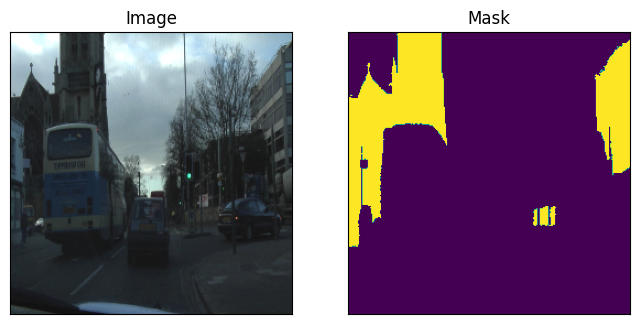

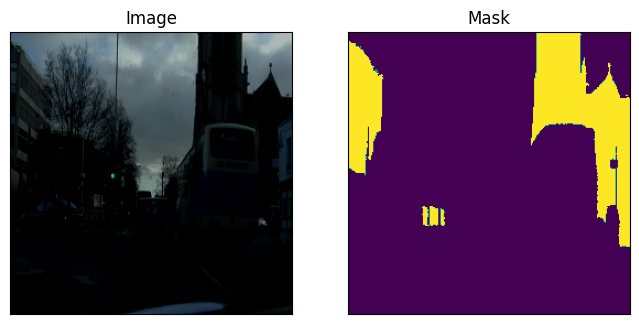

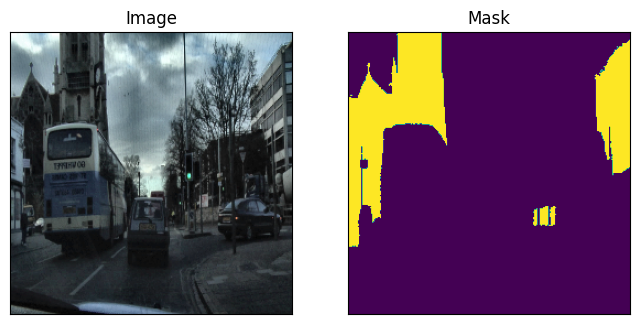

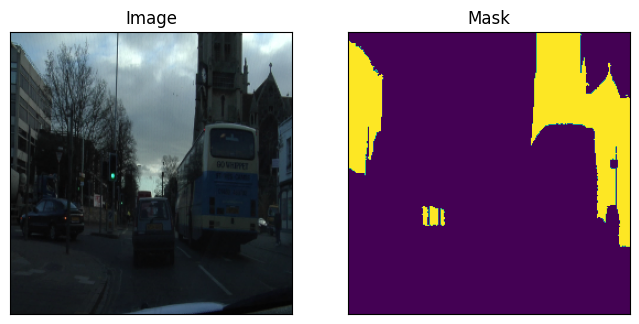

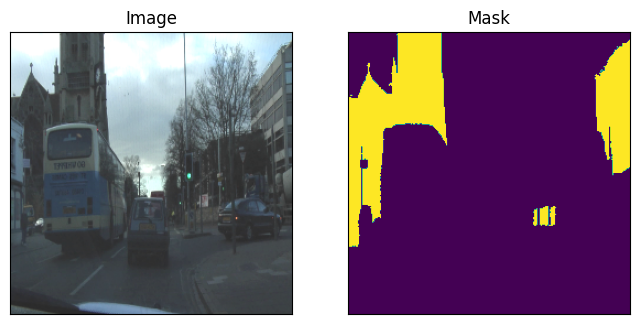

In [ ]:
# apply to custom dataset class
augmented_dataset = Cityscapes(x_train_dir,
                               y_train_dir,
                               classes=["building"],
                               augmentation=get_training_augmentation())

# visualize data augmentation
for i in range(5):
    image, mask = augmented_dataset[8]
    visualizeData(image=image, mask=mask.squeeze(-1))

## **5. Define UNet Model**

The UNet model used is an existing model at https://github.com/qubvel/segmentation_models.pytorch, where the model has been pretrained.

In [ ]:
# install and clone github segmentation models pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-9ez4byst
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-9ez4byst
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit d7a3eb0e6f55b610c2d41cce53e4c15b8f7d0ea3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cac

In [ ]:
!pip install torchsummary

In [ ]:
import segmentation_models_pytorch as smp
from torchsummary import summary

In [ ]:
# encoder use resnet50
ENCODER = "resnet50"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax"

# decoder use unet
model_unet = smp.Unet(encoder_name=ENCODER,
                      encoder_weights=ENCODER_WEIGHTS,
                      classes=len(CLASSES),
                      activation=ACTIVATION)

# normalize your data the same way as during encoder weight pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# model summary
summary(model_unet.to(DEVICE), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## **6. Defining Metric Performance, Optimizer, and Loss Function**

In [ ]:
import re

class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name

class Metric(BaseObject):
    pass

class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)

class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)

In [ ]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs

def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x

def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

jaccard = iou

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score

def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score

def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [ ]:
class JaccardLoss(Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

class L1Loss(nn.L1Loss, Loss):
    pass

class MSELoss(nn.MSELoss, Loss):
    pass

class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass

class NLLLoss(nn.NLLLoss, Loss):
    pass

class BCELoss(nn.BCELoss, Loss):
    pass

class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

In [ ]:
class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Fscore(Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Accuracy(Metric):
    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr,
            y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Recall(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return recall(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Precision(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [ ]:
metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

In [ ]:
# optimizer use adam
optimizer = torch.optim.Adam([dict(params=model_unet.parameters(), lr=0.0001)])

# define loss function
loss_fn = DiceLoss()

## **7. Training Preparation**

### a. DataLoader

In [ ]:
train_dataset = Cityscapes(x_train_dir,
                           y_train_dir,
                           augmentation=get_training_augmentation(),
                           preprocessing=get_preprocessing(preprocessing_fn),
                           classes=CLASSES)

validation_dataset = Cityscapes(x_val_dir,
                                y_val_dir,
                                augmentation=get_validation_augmentation(),
                                preprocessing=get_preprocessing(preprocessing_fn),
                                classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


### b. Training function

In [ ]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass

class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [ ]:
import sys
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs

class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [ ]:
train_epoch = TrainEpoch(
    model_unet,
    loss=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model_unet,
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

## **8. Training Process**

In [ ]:
max_score = 0

for i in range(0, 25):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(validation_loader)


Epoch: 0
valid: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, dice_loss - 0.6062, iou_score - 0.3665, accuracy - 0.9465, fscore - 0.5351, recall - 0.371, precision - 0.9663]

Epoch: 1
valid: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, dice_loss - 0.5224, iou_score - 0.5567, accuracy - 0.9622, fscore - 0.7145, recall - 0.569, precision - 0.9619]

Epoch: 2
valid: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, dice_loss - 0.4183, iou_score - 0.6095, accuracy - 0.9661, fscore - 0.7569, recall - 0.6342, precision - 0.9396]

Epoch: 3
valid: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, dice_loss - 0.3592, iou_score - 0.6797, accuracy - 0.9721, fscore - 0.8091, recall - 0.7108, precision - 0.939]

Epoch: 4
valid: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s, dice_loss - 0.3121, iou_score - 0.702, accuracy - 0.9736, fscore - 0.8246, recall - 0.7447, precision - 0.9239]

Epoch: 5
valid: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, dice_loss - 0.2865, iou_score - 0.7147, accuracy 

## **9. Save Model Trained**

In [ ]:
torch.save(model_unet.state_dict(), "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/Self-Driving_Car_UNet.pth")

## **10. Making Prediction**

In [ ]:
trained_model = smp.Unet(encoder_name="resnet50",
                         encoder_weights=None,
                         in_channels=3,
                         classes=len(CLASSES)).to(DEVICE)

# load state dict dari Google Drive
model_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/Self-Driving_Car_UNet.pth"
trained_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
trained_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# define the color palette for the classes
PALETTE = [
    (128, 64, 128), (244, 35, 232), (70, 70, 70), (102, 102, 156),
    (190, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0),
    (107, 142, 35), (152, 251, 152), (0, 130, 180), (220, 20, 60)
]

def predict_image(image_path, model, device, palette=PALETTE):
    # read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image preprocessing
    preprocess = albu.Compose([
        albu.Resize(256, 256),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    augmented = preprocess(image=image)
    image_tensor = augmented["image"].unsqueeze(0).to(device)

    # prediction
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output).cpu().numpy()[0]

    # Create an empty image for colored segmentation mask
    segmented_image = np.zeros((output.shape[1], output.shape[2], 3), dtype=np.uint8)

    # Assign colors to each class
    for class_index in range(output.shape[0]):
        mask = output[class_index] > 0.5  # Thresholding for binary mask
        segmented_image[mask] = palette[class_index]

    # Resize segmented image to original image size
    segmented_image = cv2.resize(segmented_image, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # show original image and segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.show()

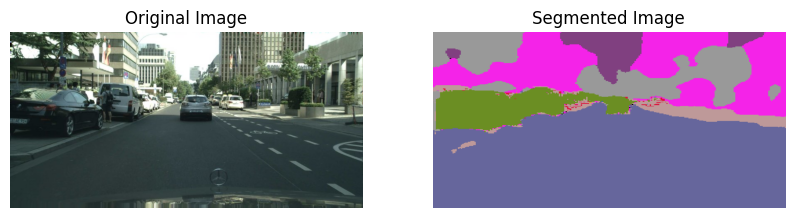

In [ ]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/image_for_prediction_1.png"
predict_image(image_path, trained_model, DEVICE)

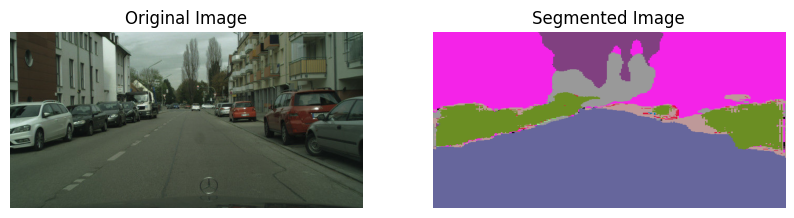

In [ ]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/image_for_prediction_2.png"
predict_image(image_path, trained_model, DEVICE)

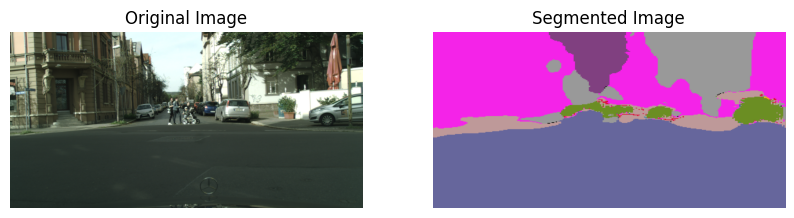

In [ ]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/image_for_prediction_3.jpg"
predict_image(image_path, trained_model, DEVICE)

## **11. Analysis of Results**

We have trained a UNet model on the Cityscapes dataset for semantic segmentation over 25 epochs. The training resulted in an Intersection over Union (IoU) score of 0.78. The IoU score is a common metric used to evaluate the accuracy of a segmentation model by comparing the overlap between the predicted segmentation and the ground truth.

### <u>Prediction Results</u>
The provided prediction result includes two images: the original input image and the segmented output image generated by the model.

1. **Original Image**:
   - The original image shows a typical urban street scene, including cars, buildings, trees, and road markings.

2. **Segmented Image**:
   - The segmented image displays the same scene, but each pixel is classified into different categories. The colors represent different classes such as road, sidewalk, building, vegetation, and sky.

### <u>Visual Evaluation</u>
1. **Road and Sidewalk**:
  - The model has successfully identified and segmented the road and sidewalk. The segmentation of these areas is consistent and matches the structure of the original image.
  
2. **Buildings and Vegetation**:
  - Buildings and vegetation are also well-segmented. The model correctly identifies the buildings and trees, although there might be some slight inaccuracies at the boundaries where different classes meet.

3. **Sky**:
  - The sky is accurately segmented, showing a clear distinction from other objects.

4. **Vehicles**:
  - Cars and other vehicles are generally well-segmented, but there may be minor inaccuracies in some areas.

### <u>Overall Performance</u>
The IoU score of 0.78 indicates a high level of accuracy for the model, especially considering the complexity of the urban scenes in the Cityscapes dataset. An IoU score close to 0.8 suggests that the model is quite effective at distinguishing between different classes and provides reliable segmentation results.

### <u>Areas for Improvement</u>
1. **Boundary Precision**:
  - While the segmentation is generally accurate, there may be some areas where the boundaries between different classes are not perfectly sharp. Improving boundary precision could further enhance the model's performance.

2. **Class Confusion**:
  - There might be occasional confusion between similar classes, such as different types of vehicles or buildings with complex textures. More training data or advanced augmentation techniques could help reduce this confusion.

3. **Fine-tuning**:
  - Fine-tuning the model with additional epochs or using advanced optimization techniques could potentially improve the IoU score and the quality of segmentation.

### <u>Conclusion</u>
The UNet model trained on the Cityscapes dataset demonstrates strong performance with an IoU score of 0.78. The segmentation results are visually consistent with the original image, accurately identifying various objects and regions within the scene. With further refinement and additional training, the model's performance could be improved even further, making it a robust tool for urban scene understanding and semantic segmentation tasks.